In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import pickle
import multiprocessing

import pyLDAvis.gensim

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [4]:
df.head()

,clean,processed
0,islam kills are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,clinton trump should ve apologized more attack...,clinton trump apologize attack little
2,who was is the best president of the past year...,well president past retweet
3,i don t have to guess your religion christmasa...,guess religion christmasaftermath
4,pence and his lawyers decided which of his off...,pence lawyer decide official email public can see


In [12]:
df['lemma_list'] = df['processed'].apply(lambda x: x.split(" "))

In [13]:
df.head()

,clean,processed,lemma_list
0,islam kills are you trying to say that there w...,islam kill try say terrorist attack europe ref...,"[islam, kill, try, say, terrorist, attack, eur..."
1,clinton trump should ve apologized more attack...,clinton trump apologize attack little,"[clinton, trump, apologize, attack, little]"
2,who was is the best president of the past year...,well president past retweet,"[well, president, past, retweet]"
3,i don t have to guess your religion christmasa...,guess religion christmasaftermath,"[guess, religion, christmasaftermath]"
4,pence and his lawyers decided which of his off...,pence lawyer decide official email public can see,"[pence, lawyer, decide, official, email, publi..."


In [14]:
id2word = Dictionary(df['lemma_list'])
print(len(id2word))

78051


In [15]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

36687


In [16]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_list']]

In [22]:
len(corpus)

203482

In [18]:
cores = multiprocessing.cpu_count()
cores

12

In [23]:
base_model = LdaMulticore(corpus=corpus, 
                          num_topics=6, 
                          id2word=id2word, 
                          workers=cores-1, 
                          passes=5)

In [26]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [27]:

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [28]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
merkel die get midnight play gt muss god r go

------ Topic 1 ------
obama  tcot pjnet islam kill stop america want us

------ Topic 2 ------
clinton hillary new email get make fbi good idea say

------ Topic 3 ------
go get woman man think like look one hillary take

------ Topic 4 ------
trump hillary clinton donald real president politic say obama news

------ Topic 5 ------
people like time thing love get see make back good



In [30]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['lemma_list'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -8.382009466938264

Coherence Score:  0.26810344212161613


### Find optimal number of topics by Coherence & Perplexity scores

In [42]:
def find_num_topics(topic_num_list, corpus, id2word):
    
    perplexity_scores = []
    coherence_scores = []
    
    for topic_num in topic_num_list:
            model = LdaMulticore(corpus=corpus, 
                                  num_topics=topic_num, 
                                  id2word=id2word, 
                                  workers=cores-1, 
                                  passes=5)
            
            # Create Topics
            words = [re.findall(r'"([^"]*)"',t[1]) for t in model.print_topics()]
            topics = [' '.join(t[0:10]) for t in words]
            
            # Getting the topics
            print(f'Number of Topics: {topic_num}')
            for id, t in enumerate(topics): 
                print(f"------ Topic {id} ------")
                print(t, end="\n\n")
                  
            # Compute Perplexity
            # a measure of how good the model is. lower the better
            perplexity = model.log_perplexity(corpus)
            print('\nPerplexity: ', perplexity) 

            # Compute Coherence Score
            coherence_model = CoherenceModel(model=model, texts=df['lemma_list'], 
                                               dictionary=id2word, coherence='c_v')
            coherence = coherence_model.get_coherence()
            print('\nCoherence Score: ', coherence)      
            print('\n\n')
            print("------END MODEL------\n")
            
            perplexity_scores.append(perplexity)
            coherence_scores.append(coherence)
            
    return perplexity_scores, coherence_scores

In [43]:
topic_num_list = [5, 10, 15, 20, 25, 30]

In [44]:
perp_scores, coh_scores = find_num_topics(topic_num_list, corpus, id2word)

Number of Topics: 5
------ Topic 0 ------
clinton hillary via merkel email die fbi r muss say

------ Topic 1 ------
hillary get obama trump say never clinton think people like

------ Topic 2 ------
trump donald real  president obama say america islam maga

------ Topic 3 ------
trump clinton hillary make news people politic new call time

------ Topic 4 ------
midnight get like go trump good love thank look well


Perplexity:  -8.394902565415423

Coherence Score:  0.19751355411585775



------END MODEL------

Number of Topics: 10
------ Topic 0 ------
obama hillary clinton think know last trump tweet go president

------ Topic 1 ------
 trump take like go real gun america donald isis

------ Topic 2 ------
people like look thing black hillary go american get clinton

------ Topic 3 ------
day get one say make come something time thank happy

------ Topic 4 ------
man get play obama trump gt woman debate watch call

------ Topic 5 ------
trump merkel islam kill muss idea die president


Perplexity:  -9.316309773017089

Coherence Score:  0.31709361164349187



------END MODEL------



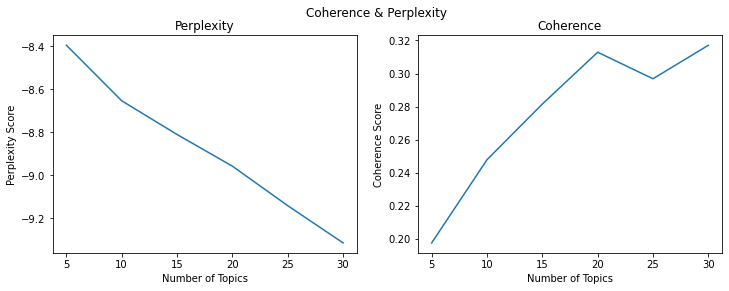

In [56]:
plt.figure(figsize=(12, 4))
plt.suptitle('Coherence & Perplexity')
plt.subplot(1, 2, 1)
plt.title('Perplexity')
plt.plot(topic_num_list, perp_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')

plt.subplot(1, 2, 2)
plt.title('Coherence')
plt.plot(topic_num_list, coh_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score');